In [1]:
import wandb
import pandas as pd
from loguru import logger
import torch
import torch.nn.functional as F
from datetime import datetime as dt
import os
from dateutil.relativedelta import relativedelta  # type: ignore
import functools

from process_data import *
from evaluate import *
from constants import *
from model import *

wandb.login()


def initialize_run():
    try:
        api = wandb.Api()
        runs = api.runs(f"{ENTITY_NAME}/{PROJECT_NAME}")
        if len(runs) == 0:
            raise Exception("No runs")
        last_iteration = float("-inf")
        end_date_of_last_iteration = None

        for run in runs:
            config = {k: v for k, v in run.config.items() if not k.startswith("_")}
            run_name = run.name
            iteration_no = int(run_name.split("_")[1])
            if iteration_no > last_iteration:
                last_iteration = iteration_no
                end_date_of_last_iteration = config["end_date"]

        current_iteration = last_iteration + 1
        current_start_date = dt.strptime(
            end_date_of_last_iteration, "%Y-%m-%d"
        ).date() + relativedelta(days=1)
    except Exception as e:
        print(e)
        current_iteration = 0
        current_start_date = dt.strptime(SIMULATION_START_DATE, "%Y-%m-%d").date()

    return current_iteration, current_start_date


# Driver code

iteration, start_date = initialize_run()
if start_date == dt.strptime(MAX_START_DATE, "%Y-%m-%d").date():
    raise Exception("Stop Simulation")
end_date, nxt_start_date = split_date_by_period_months(start_date, TOTAL_MONTHS_PER_ITERATION)

logger.info("Start of Retraining")
print(iteration)
print(start_date, end_date)
directory = "/Users/yhchan/Downloads/FYP/data/processed"
reviews = pd.read_parquet('i.parquet') #todo
listings = pd.read_parquet(f"{directory}/listings_with_interactions.parquet")

config = {
    "iteration":iteration,
    "architecture": "Rating-Weighted GraphSAGE",
    "start_date": start_date,
    "end_date": end_date,
    "learning_rate": 0.01,
    "hidden_channels": 64,
    "train_batch_size": 128,
    "test_batch_size": 128,
    "epochs": 300,
    "train_num_neighbours": [10, 10],
    "test_num_neighbours": [-1],
    "train_split_period_months": 10,
    "total_months_of_data": TOTAL_MONTHS_PER_ITERATION,
    "rec_K": 5,
}

wandb.init(
    project=PROJECT_NAME,
    config=config,
    name=f"iteration_{iteration}"
)
wandb.define_metric("train_loss", step_metric="epoch", summary="min")
wandb.define_metric("test_loss", step_metric="epoch", summary="min")

# Split into train, test and test for cold start scenario
(
    train_reviews,
    train_listings,
    train_reviewers,
    test_reviews,
    test_listings,
    test_reviewers,
) = main_train_test(
    reviews,
    listings,
    start_date,
    end_date,
    wandb.config["train_split_period_months"],
)

cold_start_test_reviews = filter_test_data_by_scenario(
    train_reviews, test_reviews, "reviewer_id", "cold_start_new_user"
)
cold_start_test_listings, cold_start_test_reviewers = build_partitioned_data(
    cold_start_test_reviews, listings
)
# Build Graph
involved_reviews = pd.concat([train_reviews, test_reviews])
involved_listings, involved_reviewers = build_partitioned_data(involved_reviews, listings)
involved_data = build_heterograph(involved_reviews, involved_listings, involved_reviewers, True)
train_data = build_heterograph(train_reviews, train_listings, train_reviewers, True)
test_data = build_heterograph(test_reviews, test_listings, test_reviewers, True)
cold_start_test_data = build_heterograph(
    cold_start_test_reviews, cold_start_test_listings, cold_start_test_reviewers, True
)
print("Whole Graph", involved_data)
print("Training Heterogenous Graph", train_data)
print("Test Heterogenous Graph", test_data)
print("Test Heterogenous Graph (Cold Start Scenerio)", cold_start_test_data)

involved_listings2dict = get_entity2dict(involved_listings, "listing_id")
reverse_involved_listings2dict = {k: v for v, k in involved_listings2dict.items()}

metadata_dict = {
    "num_reviews": len(involved_reviews),
    "num_train_reviews": len(train_reviews),
    "num_test_reviews": len(test_reviews),
    "num_cold_start_test_reviews": len(cold_start_test_reviews),
    "num_unique_listings": len(involved_listings),
    "num_unique_train_listings": len(train_listings),
    "num_unique_test_listings": len(test_listings),
    "num_unique_cold_start_test_listings": len(cold_start_test_listings),
    "num_unique_reviewers": len(involved_reviewers),
    "num_unique_train_reviewers": len(train_reviewers),
    "num_unique_test_reviewers": len(test_reviewers),
    "num_unique_cold_start_test_reviewers": len(cold_start_test_reviewers),
}

wandb.log(metadata_dict)
train_reviews.to_parquet("train/train_reviews.parquet", index=False)
train_listings.to_parquet("train/train_listings.parquet", index=False)
train_reviewers.to_parquet("train/train_reviewers.parquet", index=False)
test_reviews.to_parquet("test/test_reviews.parquet", index=False)
test_listings.to_parquet("test/test_listings.parquet", index=False)
test_reviewers.to_parquet("test/test_reviewers.parquet", index=False)
cold_start_test_reviews.to_parquet("test/cold_start_test_reviews.parquet", index=False)
cold_start_test_listings.to_parquet("test/cold_start_test_listings.parquet", index=False)
cold_start_test_reviewers.to_parquet("test/cold_start_test_reviewers.parquet", index=False)

dataset_art = wandb.Artifact(f"{start_date}_{end_date}_data", type="dataset")
for dir in ["train", "test"]:
    dataset_art.add_dir(dir)
wandb.log_artifact(dataset_art)

# Modelling
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_data = train_data.to(device)
train_loader = prepare_data_loader(
    data=train_data,
    batch_size=config["train_batch_size"],
    num_neighbours=config["train_num_neighbours"],
)
test_loader = prepare_data_loader(
    data=test_data,
    batch_size=config["test_batch_size"],
    num_neighbours=config["test_num_neighbours"],
)
model = Model(hidden_channels=config["hidden_channels"], data=involved_data).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=config["learning_rate"])

# Train and Evaluate Loss
run_eval_wrapper = functools.partial(
    run_eval,
    involved_data,
    involved_reviewers,
    involved_listings2dict,
    reverse_involved_listings2dict,
    test_reviews,
    test_reviewers,
    wandb.config["rec_K"],
)
test_wrapper = functools.partial(
    test,
    test_loader,
    device
)

best_model_path = None
best_train_loss = float("inf")
best_test_loss = float("inf")
model_prefix = "./models"
# Train and Evaluate Loss
for epoch in range(1, wandb.config["epochs"] + 1):
    model_is_best = False
    train_loss = train(model, optimizer, train_loader, device)
    test_loss = test_wrapper(model)

    if train_loss < best_train_loss:
        best_train_loss = train_loss
        wandb.run.summary["best_train_loss"] = best_train_loss

    if test_loss < best_test_loss:
        best_test_loss = test_loss
        wandb.run.summary["best_test_loss"] = best_test_loss
        model_is_best = True

    metrics_dict = {
        "train_loss": train_loss,
        "test_loss": test_loss,
        "epoch": epoch,
    }
    wandb.log(metrics_dict)
    logger.info(
        f"Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f} "
    )

    model_path = f"{model_prefix}/{epoch}_model_state_dict.pt"
    torch.save(model.state_dict(), model_path)
    model_art = wandb.Artifact(f"{MODEL_NAME}_iteration_{iteration}", type="model")
    model_art.add_file(model_path)
    wandb.log_artifact(
        model_art,
        aliases=[LATEST_TAG],
    )
    if model_is_best:
        best_model_path = model_path

production_model = None
try:
    production_model_dir = wandb.use_artifact(
        f"{ENTITY_NAME}/{PROJECT_NAME}/{MODEL_REGISTRY_NAME}:{PRODUCTION_TAG}"
    ).download()
    production_model_path = f"{production_model_dir}/{os.listdir(production_model_dir)[0]}"
    production_model = load_model(
        production_model_path, wandb.config["hidden_channels"], involved_data
    )
    logger.info("Production model found")
except Exception as e:
    print(e)
    logger.info("No production model found")


contender_model = load_model(best_model_path, wandb.config["hidden_channels"], involved_data)
contender_model_metrics = run_eval_wrapper(contender_model)
contender_model_metrics_dict = {
    f"contender_model_u2i_hit_rate@{config['rec_K']}": contender_model_metrics[0],
    "contender_model_u2i_coverage": contender_model_metrics[1],
    f"contender_model_i2i_hit_rate@{config['rec_K']}": contender_model_metrics[2],
    "contender_model_i2i_coverage": contender_model_metrics[3],
}
wandb.log(contender_model_metrics_dict)

if production_model == None:
    is_contender_model_better = True
else:
    test_loss_by_production_model = test_wrapper(production_model)
    production_model_metrics = run_eval_wrapper(production_model)
    production_model_metrics_dict =  {
            "production_model_test_loss": test_loss_by_production_model,
            f"production_model_u2i_hit_rate@{config['rec_K']}": production_model_metrics[0],
            "production_model_u2i_coverage": production_model_metrics[1],
            f"production_model_i2i_hit_rate@{config['rec_K']}": production_model_metrics[2],
            "production_model_i2i_coverage": production_model_metrics[3],
    }
    wandb.log(production_model_metrics_dict)
    is_contender_model_better = (
        best_test_loss < production_model_metrics_dict['production_model_test_loss'] 
        and contender_model_metrics_dict[f"contender_model_u2i_hit_rate@{config['rec_K']}"] > production_model_metrics_dict[f"production_model_u2i_hit_rate@{config['rec_K']}"]
        and contender_model_metrics_dict[f"contender_model_i2i_hit_rate@{config['rec_K']}"] > production_model_metrics_dict[f"production_model_i2i_hit_rate@{config['rec_K']}"]
    )
model_registry_art = wandb.Artifact(MODEL_REGISTRY_NAME, type="model_registry")
model_registry_art.add_file(best_model_path)
# By right, it should go through shadow deployment or A/B Testing first before pushing it to production
wandb.log_artifact(
    model_registry_art,
    aliases=[PRODUCTION_TAG] if is_contender_model_better else [ARCHIVED_TAG],
)
# Save code
wandb.run.log_code(
    "./", include_fn=lambda path: path.endswith(".py") or path.endswith(".ipynb")
)
wandb.finish()
logger.info("End of Retraining")


wandb: Currently logged in as: yhchan0918. Use `wandb login --relogin` to force relogin
2023-05-01 00:42:09.121 | INFO     | __main__:<module>:55 - Start of Retraining


6
2021-10-24 2022-10-23


2023-05-01 00:42:22.669 | INFO     | process_data:main_train_test:140 - Split df into train and test portion
/Users/yhchan/Downloads/FYP/CT_Recsys/ct_pipeline/process_data.py:172: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1670525682339/work/torch/csrc/utils/tensor_numpy.cpp:205.)
  temp = torch.from_numpy(val).view(-1, 1).to(torch.float32)


Whole Graph HeteroData(
  listing={ x=[18523, 158] },
  user={ x=[394551, 384] },
  (user, rates, listing)={
    edge_index=[2, 408596],
    edge_label=[408596],
    edge_label_index=[2, 408596]
  },
  (listing, rev_rates, user)={ edge_index=[2, 408596] }
)
Training Heterogenous Graph HeteroData(
  listing={ x=[17229, 158] },
  user={ x=[324135, 384] },
  (user, rates, listing)={
    edge_index=[2, 334678],
    edge_label=[334678],
    edge_label_index=[2, 334678]
  },
  (listing, rev_rates, user)={ edge_index=[2, 334678] }
)
Test Heterogenous Graph HeteroData(
  listing={ x=[14380, 158] },
  user={ x=[72447, 384] },
  (user, rates, listing)={
    edge_index=[2, 73918],
    edge_label=[73918],
    edge_label_index=[2, 73918]
  },
  (listing, rev_rates, user)={ edge_index=[2, 73918] }
)
Test Heterogenous Graph (Cold Start Scenerio) HeteroData(
  listing={ x=[14254, 158] },
  user={ x=[70416, 384] },
  (user, rates, listing)={
    edge_index=[2, 71775],
    edge_label=[71775],
    edge_l

wandb: Adding directory to artifact (./train)... Done. 5.4s
wandb: Adding directory to artifact (./test)... Done. 8.3s
2023-05-01 00:43:29.960 | INFO     | __main__:<module>:215 - Epoch: 001, Train Loss: 0.6283, Test Loss: 1.1542 
2023-05-01 00:43:51.943 | INFO     | __main__:<module>:215 - Epoch: 002, Train Loss: 0.5371, Test Loss: 0.9957 
2023-05-01 00:44:43.119 | INFO     | __main__:<module>:215 - Epoch: 003, Train Loss: 0.4214, Test Loss: 1.0054 
2023-05-01 00:45:33.575 | INFO     | __main__:<module>:215 - Epoch: 004, Train Loss: 0.3317, Test Loss: 1.0004 
2023-05-01 00:46:24.127 | INFO     | __main__:<module>:215 - Epoch: 005, Train Loss: 0.2829, Test Loss: 0.9792 
2023-05-01 00:47:14.692 | INFO     | __main__:<module>:215 - Epoch: 006, Train Loss: 0.2481, Test Loss: 0.8811 
2023-05-01 00:48:05.301 | INFO     | __main__:<module>:215 - Epoch: 007, Train Loss: 0.2200, Test Loss: 0.9237 
2023-05-01 00:49:09.925 | INFO     | __main__:<module>:215 - Epoch: 008, Train Loss: 0.2024, Test

2023-05-01 01:12:35.819 | INFO     | __main__:<module>:215 - Epoch: 069, Train Loss: 0.0493, Test Loss: 0.8517 
2023-05-01 01:12:58.714 | INFO     | __main__:<module>:215 - Epoch: 070, Train Loss: 0.0493, Test Loss: 0.8349 
2023-05-01 01:13:21.648 | INFO     | __main__:<module>:215 - Epoch: 071, Train Loss: 0.0467, Test Loss: 0.8542 
2023-05-01 01:13:44.879 | INFO     | __main__:<module>:215 - Epoch: 072, Train Loss: 0.0500, Test Loss: 0.8487 
2023-05-01 01:14:08.731 | INFO     | __main__:<module>:215 - Epoch: 073, Train Loss: 0.0507, Test Loss: 0.8643 
2023-05-01 01:14:31.984 | INFO     | __main__:<module>:215 - Epoch: 074, Train Loss: 0.0489, Test Loss: 0.8647 
2023-05-01 01:14:55.420 | INFO     | __main__:<module>:215 - Epoch: 075, Train Loss: 0.0472, Test Loss: 0.8588 
2023-05-01 01:15:18.879 | INFO     | __main__:<module>:215 - Epoch: 076, Train Loss: 0.0486, Test Loss: 0.8345 
2023-05-01 01:15:41.807 | INFO     | __main__:<module>:215 - Epoch: 077, Train Loss: 0.0475, Test Loss: 

2023-05-01 01:39:16.476 | INFO     | __main__:<module>:215 - Epoch: 143, Train Loss: 0.0360, Test Loss: 0.7916 
2023-05-01 01:39:36.827 | INFO     | __main__:<module>:215 - Epoch: 144, Train Loss: 0.0353, Test Loss: 0.8065 
2023-05-01 01:39:57.218 | INFO     | __main__:<module>:215 - Epoch: 145, Train Loss: 0.0358, Test Loss: 0.7972 
2023-05-01 01:40:17.571 | INFO     | __main__:<module>:215 - Epoch: 146, Train Loss: 0.0351, Test Loss: 0.8007 
2023-05-01 01:40:38.034 | INFO     | __main__:<module>:215 - Epoch: 147, Train Loss: 0.0346, Test Loss: 0.8130 
2023-05-01 01:40:58.521 | INFO     | __main__:<module>:215 - Epoch: 148, Train Loss: 0.0360, Test Loss: 0.8119 
2023-05-01 01:41:18.716 | INFO     | __main__:<module>:215 - Epoch: 149, Train Loss: 0.0353, Test Loss: 0.7959 
2023-05-01 01:41:38.933 | INFO     | __main__:<module>:215 - Epoch: 150, Train Loss: 0.0346, Test Loss: 0.8106 
2023-05-01 01:41:59.087 | INFO     | __main__:<module>:215 - Epoch: 151, Train Loss: 0.0365, Test Loss: 

2023-05-01 02:04:05.641 | INFO     | __main__:<module>:215 - Epoch: 217, Train Loss: 0.0304, Test Loss: 0.8372 
2023-05-01 02:04:26.136 | INFO     | __main__:<module>:215 - Epoch: 218, Train Loss: 0.0299, Test Loss: 0.8225 
2023-05-01 02:04:46.102 | INFO     | __main__:<module>:215 - Epoch: 219, Train Loss: 0.0302, Test Loss: 0.8170 
2023-05-01 02:05:09.072 | INFO     | __main__:<module>:215 - Epoch: 220, Train Loss: 0.0305, Test Loss: 0.8391 
2023-05-01 02:05:29.127 | INFO     | __main__:<module>:215 - Epoch: 221, Train Loss: 0.0312, Test Loss: 0.8339 
2023-05-01 02:05:49.011 | INFO     | __main__:<module>:215 - Epoch: 222, Train Loss: 0.0307, Test Loss: 0.8161 
2023-05-01 02:06:08.914 | INFO     | __main__:<module>:215 - Epoch: 223, Train Loss: 0.0298, Test Loss: 0.8350 
2023-05-01 02:06:28.618 | INFO     | __main__:<module>:215 - Epoch: 224, Train Loss: 0.0288, Test Loss: 0.8369 
2023-05-01 02:06:48.636 | INFO     | __main__:<module>:215 - Epoch: 225, Train Loss: 0.0301, Test Loss: 

2023-05-01 02:28:52.164 | INFO     | __main__:<module>:215 - Epoch: 291, Train Loss: 0.0270, Test Loss: 0.8524 
2023-05-01 02:29:12.408 | INFO     | __main__:<module>:215 - Epoch: 292, Train Loss: 0.0267, Test Loss: 0.8400 
2023-05-01 02:29:32.429 | INFO     | __main__:<module>:215 - Epoch: 293, Train Loss: 0.0263, Test Loss: 0.9599 
2023-05-01 02:29:52.500 | INFO     | __main__:<module>:215 - Epoch: 294, Train Loss: 0.0268, Test Loss: 0.8453 
2023-05-01 02:30:12.707 | INFO     | __main__:<module>:215 - Epoch: 295, Train Loss: 0.0264, Test Loss: 0.8930 
2023-05-01 02:30:32.909 | INFO     | __main__:<module>:215 - Epoch: 296, Train Loss: 0.0265, Test Loss: 0.8593 
2023-05-01 02:30:53.077 | INFO     | __main__:<module>:215 - Epoch: 297, Train Loss: 0.0267, Test Loss: 0.8426 
2023-05-01 02:31:13.120 | INFO     | __main__:<module>:215 - Epoch: 298, Train Loss: 0.0269, Test Loss: 0.8452 
2023-05-01 02:31:33.364 | INFO     | __main__:<module>:215 - Epoch: 299, Train Loss: 0.0265, Test Loss: 

K = 5
Start generating embeddings
Finish generating embeddings
Start u2i recommendation


/Users/yhchan/Downloads/FYP/CT_Recsys/ct_pipeline/evaluate.py:108: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(recommendations), np.array(ground_truths)


Length of recommendations: 72447, Length of ground truth: 72447
Count of hit & non-hit:  Counter({1: 72366, 0: 81})
n_unique_recommendations:  18176
n_available_listings:  18523
u2i hit rate:  0.9988819412812124
u2i coverage:  0.9812665334988933
Start i2i recommendation


/Users/yhchan/Downloads/FYP/CT_Recsys/ct_pipeline/evaluate.py:108: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(recommendations), np.array(ground_truths)


Length of recommendations: 1349, Length of ground truth: 1349
Count of hit & non-hit:  Counter({0: 1265, 1: 84})
n_unique_recommendations:  4722
n_available_listings:  18523
i2i hit rate:  0.06226834692364715
i2i coverage:  0.2549263078335043
K = 5
Start generating embeddings
Finish generating embeddings
Start u2i recommendation
Length of recommendations: 72447, Length of ground truth: 72447
Count of hit & non-hit:  Counter({0: 65323, 1: 7124})
n_unique_recommendations:  3376
n_available_listings:  18523
u2i hit rate:  0.098333954477066
u2i coverage:  0.18225989310586838
Start i2i recommendation


/Users/yhchan/Downloads/FYP/CT_Recsys/ct_pipeline/evaluate.py:108: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(recommendations), np.array(ground_truths)


Length of recommendations: 1349, Length of ground truth: 1349
Count of hit & non-hit:  Counter({0: 1283, 1: 66})
n_unique_recommendations:  4621
n_available_listings:  18523
i2i hit rate:  0.04892512972572276
i2i coverage:  0.24947362738217352


contender_model_i2i_coverage,▁
contender_model_i2i_hit_rate@5,▁
contender_model_u2i_coverage,▁
contender_model_u2i_hit_rate@5,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
num_cold_start_test_reviews,▁
num_reviews,▁
num_test_reviews,▁
num_train_reviews,▁
num_unique_cold_start_test_listings,▁
num_unique_cold_start_test_reviewers,▁


2023-05-01 02:46:29.000 | INFO     | __main__:<module>:285 - End of Retraining


## Data Visualization

In [1]:
import wandb
import pandas as pd

wandb.login()

wandb: Currently logged in as: yhchan0918. Use `wandb login --relogin` to force relogin


True

In [2]:
api = wandb.Api()
entity, project = ENTITY_NAME , PROJECT_NAME
runs = api.runs(entity + "/" + project) 

summary_list, config_list, name_list = [], [], []
for run in runs: 
    # .summary contains output keys/values for 
    # metrics such as accuracy.
    #  We call ._json_dict to omit large files 
    summary_list.append(run.summary._json_dict)

    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    config_list.append(
        {k: v for k,v in run.config.items()
         if not k.startswith('_')})

    # .name is the human-readable name of the run.
    name_list.append(run.name)

runs_df = pd.DataFrame({
    "summary": summary_list,
    "config": config_list,
    "name": name_list
    })

In [32]:
def get_val(x, sub_key):
    if sub_key in x:
        return x[sub_key]
    return None

key_dict = {
    "config":['start_date', 'iteration'],
    "summary": ['production_model_u2i_hit_rate@5', 'production_model_u2i_coverage','production_model_i2i_hit_rate@5','production_model_i2i_coverage'
               ,'contender_model_u2i_hit_rate@5', 'contender_model_u2i_coverage','contender_model_i2i_hit_rate@5','contender_model_i2i_coverage'
               
               ]
}

for key in key_dict:
    for col in key_dict[key]:
        runs_df[col] = runs_df[key].apply(lambda x :get_val(x, col))

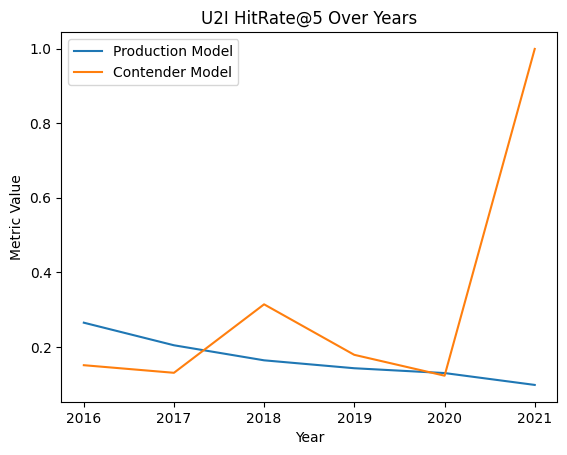

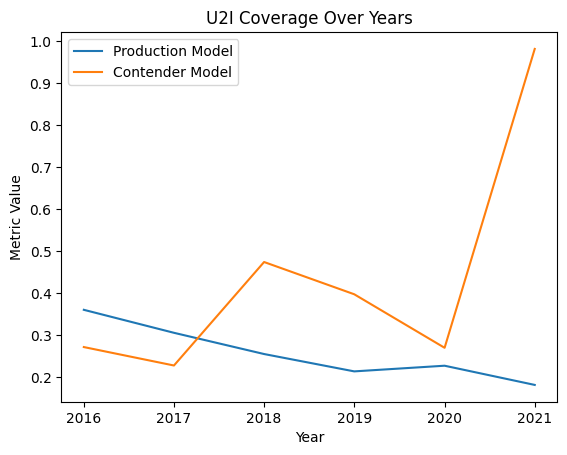

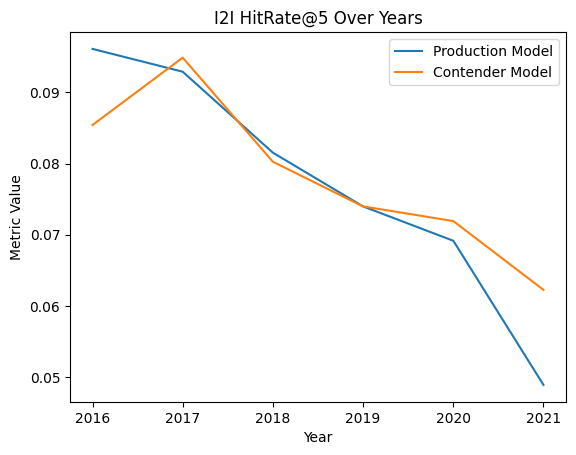

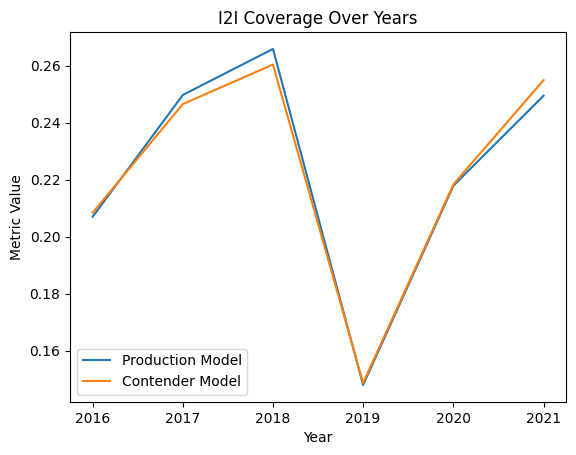

In [56]:
import pandas as pd
import matplotlib.pyplot as plt

df = runs_df.copy()
df['start_date'] = pd.to_datetime(df['start_date'])
df = df[df['iteration']>0]

metric_dict = {
    "u2i_hit_rate@5": "U2I HitRate@5 Over Years",
    "u2i_coverage": "U2I Coverage Over Years",
    "i2i_hit_rate@5": "I2I HitRate@5 Over Years",
    "i2i_coverage": "I2I Coverage Over Years",
}

for col_suffix in metric_dict:
    title = metric_dict[col_suffix]
    
    # Create line plot
    plt.plot(df['start_date'], df[f'production_model_{col_suffix}'], label='Production Model')
    plt.plot(df['start_date'], df[f'contender_model_{col_suffix}'], label='Contender Model')
    
    plt.xticks(df['start_date'], [x.strftime('%Y') for x in df['start_date']])
    # Add labels and legend
    plt.xlabel('Year')
    plt.ylabel('Metric Value')
    plt.title(title)
    plt.legend()

    # Show plot
    plt.show()
